# Multilayer Perceptron (MLP)

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/02_deeplearning/01_mlp/mlp.ipynb)
- Unofficial notebook (pytorch): [Github](https://github.com/terrence-ou/Generative-Deep-Learning-2nd-Edition-PyTorch-JAX/blob/main/PyTorch/chapter_02_deeplearning/01_MLP.ipynb)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import v2

from torchmetrics.classification import Accuracy, ConfusionMatrix

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.utilities import disable_possible_user_warnings
disable_possible_user_warnings()

In [ ]:
L.seed_everything(42)

Seed set to 42


42

## 0. Parameters

In [ ]:
NUM_CLASSES = 10

## 1. Prepare the Data

In [ ]:
class CIFAR10DataModule(L.LightningDataModule):
    def __init__(self, root="./data", batch_size=32):
        super().__init__()
        self.root = root
        self.batch_size = batch_size

    def prepare_data(self):
        datasets.CIFAR10(self.root, train=True, download=True)
        datasets.CIFAR10(self.root, train=False, download=True)

    def setup(self, stage):
        transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.ToPureTensor(),
        ])

        self.dataset_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        dataset_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

        n_val = int(len(dataset_test)*0.2)
        n_test = len(dataset_test) - n_val

        self.dataset_test, self.dataset_val = torch.utils.data.random_split(
            dataset_test, 
            [n_test, n_val],
            generator=torch.Generator().manual_seed(42)
        )
        
    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size, shuffle=False)

In [ ]:
dm = CIFAR10DataModule()
dm.prepare_data()
dm.setup('train')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"Train: {len(dm.dataset_train)}")
print(f"Val: {len(dm.dataset_val)}")
print(f"Test: {len(dm.dataset_test)}")

Train: 50000
Val: 2000
Test: 8000


In [ ]:
id2cls = {i: cls for i, cls in enumerate(dm.dataset_train.classes)}
id2cls

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [ ]:
dm.dataset_val[0][0].shape, dm.dataset_val[0][1]

(torch.Size([3, 32, 32]), 1)

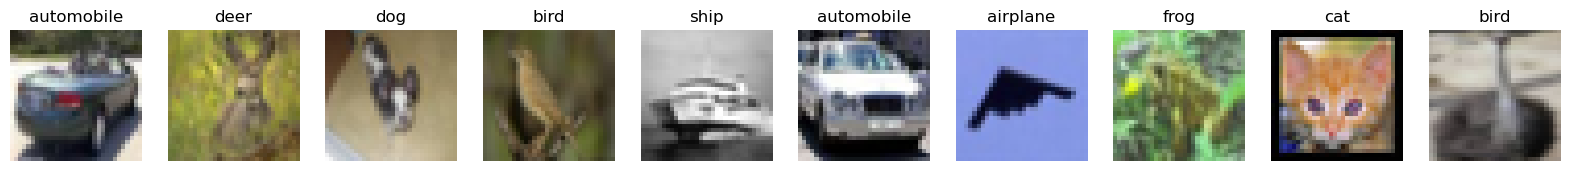

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(dm.dataset_val[i][0].permute(1, 2, 0))
    plt.title(id2cls[dm.dataset_val[i][1]])
    plt.axis("off")

plt.show()

In [ ]:
batch = next(iter(dm.val_dataloader()))
images, labels = batch
images.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

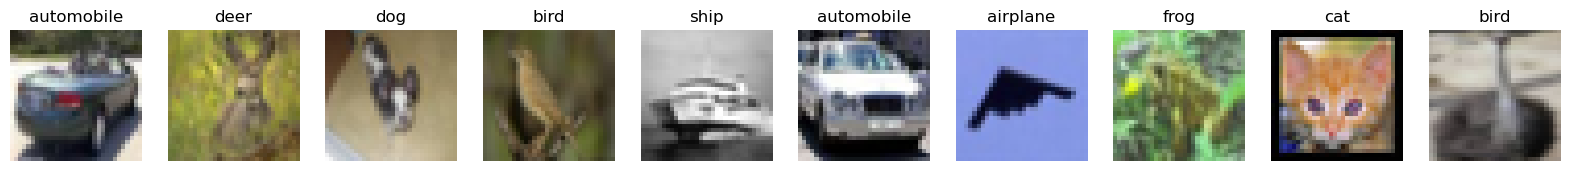

In [ ]:
n = 10
plt.figure(figsize=(20, 3))
for i in range(n):
    _ = plt.subplot(1, n, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(id2cls[labels[i].item()])
    plt.axis("off")

plt.show()

## 2. Build the model

In [ ]:
class MLP(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),

            nn.LazyLinear(200),
            nn.ReLU(),

            nn.LazyLinear(150),
            nn.ReLU(),

            nn.LazyLinear(num_classes),
        )

    def forward(self, x):
        return self.layers(x)

## 3. Train the model

In [ ]:
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("medium")

In [ ]:
class LitMLP(L.LightningModule):
    def __init__(self, num_classes, learning_rate=0.0005, input_size=(3, 32, 32)):
        super().__init__()

        self.model = MLP(num_classes=NUM_CLASSES)
        self.learning_rate = learning_rate
        self.example_input_array = torch.randn(1, *input_size)

        self.save_hyperparameters(ignore=["input_size"])

        self.criterion = nn.CrossEntropyLoss()

        self.train_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.test_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)

        self.acc_per_cls = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average=None)
        self.confmat = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch):
        images, labels = batch
        logits = self(images)

        loss = self.criterion(logits, labels)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, labels
    
    def training_step(self, batch, batch_idx):
        loss, preds, labels = self._shared_step(batch)
        self.train_acc(preds, labels)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, preds, labels = self._shared_step(batch)
        self.val_acc(preds, labels)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, preds, labels = self._shared_step(batch)
        self.test_acc(preds, labels)
        self.acc_per_cls(preds, labels)
        self.confmat(preds, labels)
        self.log('test_loss', loss)
        self.log('test_acc', self.test_acc)
        return loss
    
    def predict_step(self, batch, batch_idx):
        images, labels = batch
        logits = self(images)
        preds = torch.argmax(logits, dim=1)
        return preds, labels
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc"),
]
logger = CSVLogger(save_dir="logs/", name="cifar10_mlp")

trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices=[0],
    callbacks=callbacks,
    logger=logger,
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
dm = CIFAR10DataModule()
model = LitMLP(num_classes=NUM_CLASSES, learning_rate=0.0005)

In [ ]:
trainer.fit(model, dm)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                      | Params | Mode  | In sizes       | Out sizes
-----------------------------------------------------------------------------------------------
0 | model       | MLP                       | 646 K  | train | [1, 3, 32, 32] | [1, 10]  
1 | criterion   | CrossEntropyLoss          | 0      | train | ?              | ?        
2 | train_acc   | MulticlassAccuracy        | 0      | train | ?              | ?        
3 | val_acc     | MulticlassAccuracy        | 0      | train | ?              | ?        
4 | test_acc    | MulticlassAccuracy        | 0      | train | ?              | ?        
5 | acc_per_cls | MulticlassAccuracy        | 0      | train | ?              | ?        
6 | confmat     | MulticlassConfusionMatrix | 0      | train | ?              | ?        
-----------------------------------------------------------------------------------------------
646 K     Trainable params
0         Non-trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


<Axes: xlabel='Epoch', ylabel='Accuracy'>

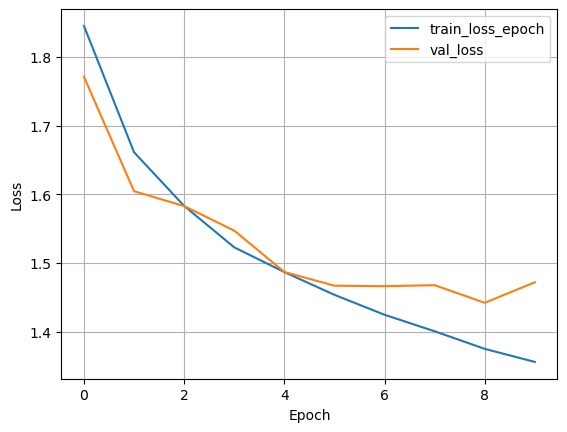

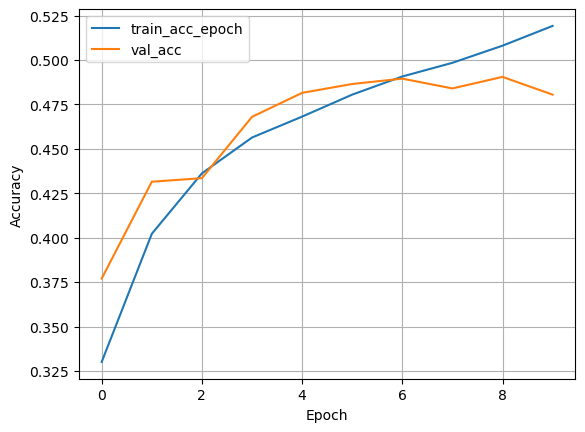

In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss_epoch", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

df_metrics[["train_acc_epoch", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy"
)

## 4. Evaluation

In [ ]:
trainer.test(model=model, datamodule=dm)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.48887500166893005
        test_loss           1.4502469301223755
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.4502469301223755, 'test_acc': 0.48887500166893005}]

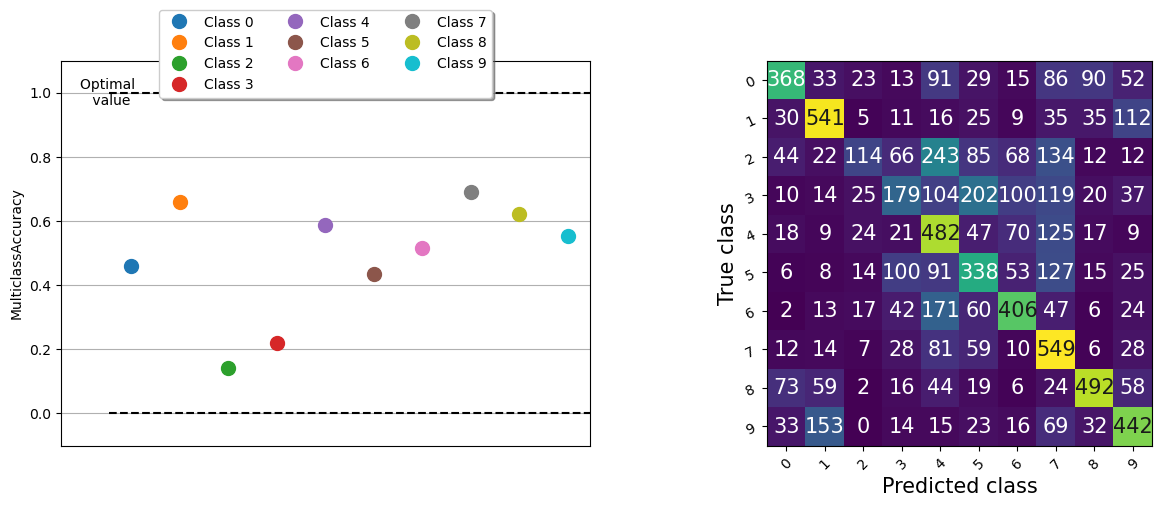

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
model.acc_per_cls.plot(ax=axes[0])
model.confmat.plot(ax=axes[1])
plt.show()

In [ ]:
predictions = trainer.predict(model=model, dataloaders=dm.test_dataloader())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
test_preds = torch.concatenate([p[0] for p in predictions])
test_labels = torch.concatenate([p[1] for p in predictions])

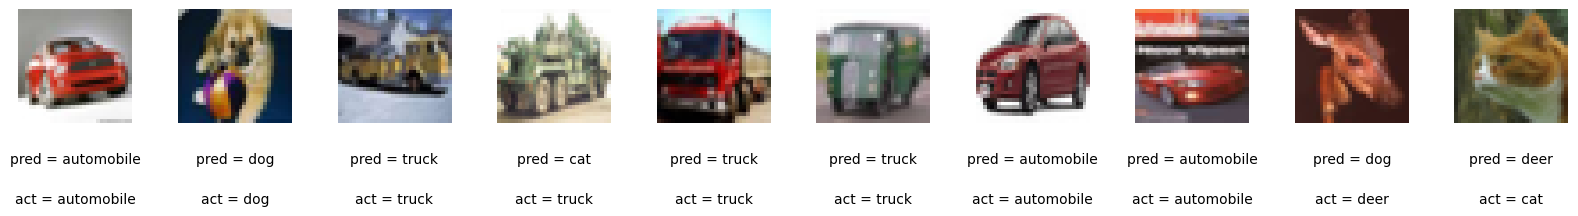

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(dm.dataset_test)), n_to_show)

fig = plt.figure(figsize=(20, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = dm.dataset_test[idx][0].permute(1, 2, 0)
    
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + id2cls[test_preds[idx].item()],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + id2cls[test_labels[idx].item()],
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)